# Multi-Element Airfoil

In [1]:
import numpy as np
import pandas as pd

import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

import logging

logging.getLogger().setLevel(logging.INFO)

matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

In [2]:
interactive_plot = True

In [3]:
# Read and panel airfoil data
MAIN = vft.read_selig("airfoils/main_element.dat")[:, ::-1]
MAIN = vft.repanel(MAIN, N=200)  # 180

HINGE = 0.8 + 0.015
center = np.r_[HINGE, 0.0]

FLAP00 = vft.repanel(vft.read_selig("airfoils/NLR7301FlapECARP.dat"), N=220)[:, ::-1]
_min = FLAP00[0].min()
FLAP00[0, :] += -_min
FLAP00[0, :] += HINGE

def rotate(deg, center, x):
    """Rotate airfoil.

    Parameters
    ----------
    deg : float
    center : numpy.array
    x : numpy.array

    Returns
    -------
    moved : numpy.array
    """

    # Create rotation matrix
    deg2rad = np.pi / 180
    c, s = np.cos(deg * deg2rad), np.sin(deg * deg2rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.
    moved = ((A @ ((x.T - center.T).T)).T + center.T).T
    # moved = ((A @ ((x.T).T)).T).T

    return moved

<IPython.core.display.Javascript object>


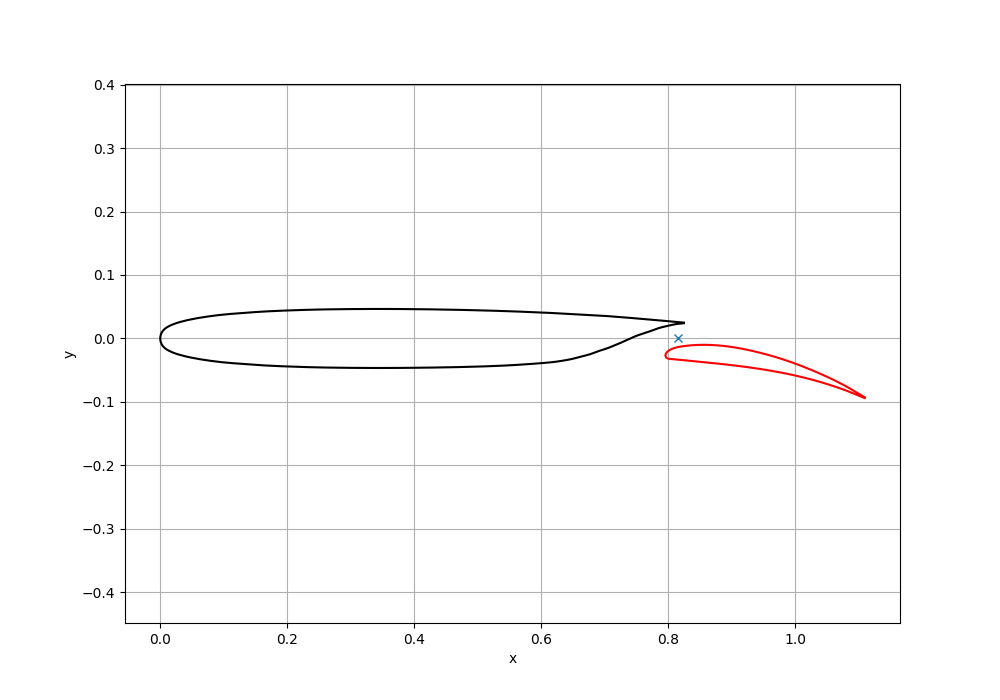

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

In [35]:
# Rotate flap

#FLAP0[0, :] += HINGE
#FLAP = rotate(20, center, FLAP0)
#FLAP[1, :] += 0.02

FLAP1 = rotate(-2, center, FLAP00)
FLAP1[1, :] *= 1
FLAP1[1, :] += 0.0
FLAP1[0, :] += -0.02

# Plot geometry
fig, ax = plt.subplots(1, 1)
ax.plot(MAIN[0, :], MAIN[1, :], "-k")
ax.plot(FLAP1[0, :], FLAP1[1, :], "-r")
ax.plot(center[0], center[1], marker="x")
ax.axis("equal")
ax.grid()
ax.set(xlabel="x", ylabel="y")

<IPython.core.display.Javascript object>


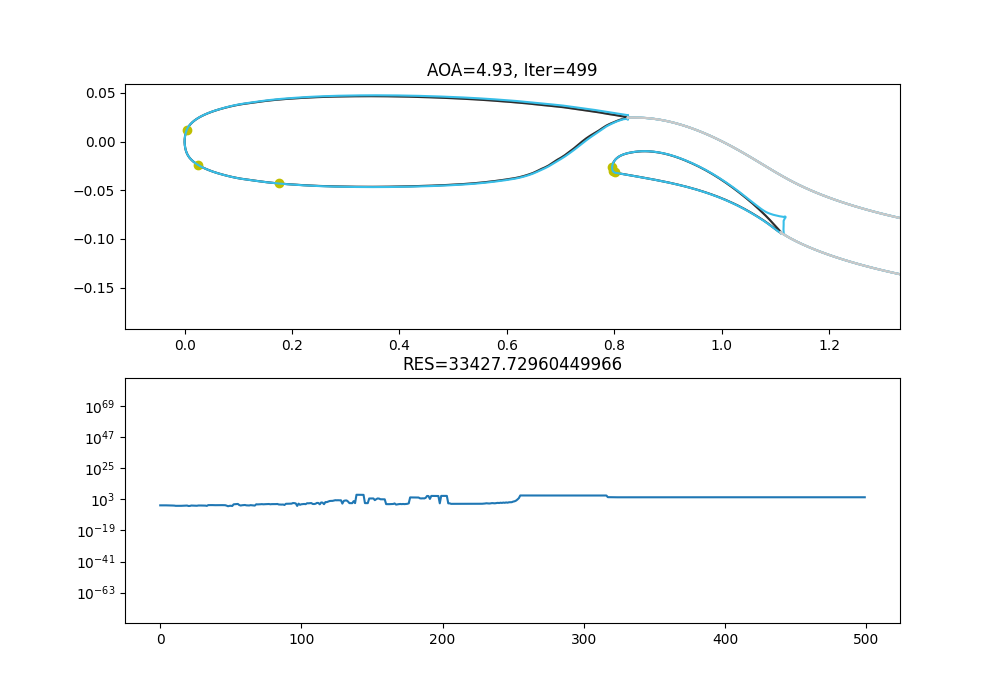

In [36]:
if interactive_plot:
    %matplotlib notebook
    matplotlib.rcParams['figure.figsize'] = [10, 7] 
    lines = None
    fig, axes = plt.subplots(2,1)
    
    axes = axes.flatten()
    
    ax_airfoil = axes[0]
    ax_residual = axes[1]
    
else:
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = [12, 6]
%config InlineBackend.figure_format = 'svg'

In [38]:
# BASE = vft.repanel(vft.read_selig("S1210Base.dat"),230)
# SLOT = vft.repanel(vft.read_selig("S1210Slot.dat"),200)
# SLOT0 = vft.read_selig("S1210Slot0.dat") # Actual slot shape


# Virtual displacement
[vdFlap, FLAPD] = vft.virtual_displacement_from_geometry(FLAP1, FLAP1)
vdFlap[0] = 0.0
vdFlap[-1] = 0.0

AOARANGE = [-2.08, 0.01, 4.93]

# Setup
RE = 1e8
ncrit = 9
Mach = 0.0

In [39]:
AOA0 = AOARANGE[-1]

s = vf.setup(Re=RE, Ma=Mach, Ncrit=ncrit, Alpha=AOA0)

s.IterateWakes = True
s.Itermax = 1
s.Silent = True
s.Tolerance = 1e-3

# Set-up and initialize based on inviscid panel solution
(p, bl, xn) = vf.init([MAIN, FLAP1], s)

# Plot geometry
if interactive_plot:
    lines = vfp.plot_geometry(ax_airfoil, p, bl, lines)

d:\envs\high_lift\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
d:\envs\high_lift\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [41]:
# xn = x.copy()
alv = []
clv = []
cdv = []

for alpha in AOARANGE:
    
    s = vf.setup(Re=RE, Ma=Mach, Ncrit=ncrit, Alpha=AOA0)

    s.IterateWakes = True
    s.Itermax = 1
    s.Silent = True
    s.Tolerance = 1e-3
    s.StepsizeLimit = 0.05 # Restricting the stepsize is beneficial here for some AOA
    # s.IncompressibleBL = 1

    s.Alpha = alpha
    
    # Set-up and initialize based on inviscid panel solution
    (p, bl, xn) = vf.init([MAIN, FLAP1], s)

    res = None
    grad = None

    residual_path = []
    
    num = int(500 / s.Itermax)
    for iteration in range(num):

        # Make effectively 100 iterations, but show some in between
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, s, res, grad, [None, vdFlap])
        # [xn, flag, res, grad, _] = vf.iter(xn, bl, p, s, res, grad)

        # Compute residual
        nres = np.sqrt(np.dot(res.T, res))
        residual_path.append(nres)
        
        # Plot geometry
        if interactive_plot:
            lines = vfp.plot_geometry(ax_airfoil, p, bl, lines)
            ax_residual.clear()
            _ = ax_residual.plot(residual_path)
            ax_residual.set_yscale('log')

        title_airfoil = f"AOA={alpha}, Iter={iteration}" 
        title_residual = f"RES={nres}" 

        ax_airfoil.set_title(title_airfoil)
        ax_residual.set_title(title_residual)

        fig.canvas.draw()

        if flag:
            alv.append(alpha)
            clv.append(p.CL)
          
            cdv.append(bl[0].CD + bl[1].CD)
            # cdv.append(bl[0].CD)
            print("AL: %f CL: %f CD: %f" % (alpha, clv[-1], cdv[-1]))
            break

AL: -2.080000 CL: 1.020235 CD: 0.007319


 xi=0.058330,delta=0.000002,theta=0.000001,ue=16.325868,typ=turbulent,
 res=[0.318793,-0.656214,4.27935e-05]
 dx=[-8.32398e-07,6.78403,-0.00132885]
 x=[1.44546e-06,16.3259,0.0118267] 
 lam=0.401086 H=1.553766 HS=1.703558 US=0.486025.

 xi=0.058325,delta=0.000001,theta=0.000001,ue=15.188887,typ=turbulent,
 res=[-0.985432,-1.34058,0.000162896]
 dx=[1.61023e-05,-174.932,-0.171692]
 x=[9.75198e-07,15.1889,0.0121376] 
 lam=0.010094 H=1.434698 HS=1.754737 US=0.557088.

 xi=0.057153,delta=0.000001,theta=0.000000,ue=26.723995,typ=turbulent,
 res=[-2.49496,-0.792392,0.000222136]
 dx=[8.24729e-07,-42.6694,-0.00422604]
 x=[4.09872e-07,26.724,0.00831795] 
 lam=0.082830 H=1.640931 HS=1.688471 US=0.446947.

 xi=0.057215,delta=0.000000,theta=0.000000,ue=48.500186,typ=turbulent,
 res=[-0.60765,-0.731336,0.000186035]
 dx=[1.52146e-07,-41.1331,0.000876458]
 x=[2.58109e-07,48.5002,0.00550887] 
 lam=0.282742 H=1.856497 HS=1.629006 US=0.361766.

 xi=0.057726,delta=0.000000,theta=0.000000,ue=100.961431,typ=

 xi=0.006273,delta=0.000001,theta=0.000001,ue=3.321837,typ=turbulent,
 res=[1.76809,-2.24915,0.00196569]
 dx=[1.14171e-06,-1.83209,-0.0134139]
 x=[9.70033e-07,3.32184,0.00830666] 
 lam=0.131923 H=1.120087 HS=1.928440 US=0.839670.

 xi=0.006273,delta=0.000001,theta=0.000000,ue=6.049867,typ=turbulent,
 res=[3.10215,-3.89545,0.00217123]
 dx=[-1.46093e-06,7.71764,0.0193628]
 x=[4.60565e-07,6.04987,0.00718365] 
 lam=0.061834 H=1.527359 HS=1.758450 US=0.513473.

 xi=0.059372,delta=0.000000,theta=0.000000,ue=939.250671,typ=turbulent,
 res=[1.22032,-1.71298,5.2318e-05]
 dx=[2.03659e-08,-1175.79,-0.00092777]
 x=[5.23064e-08,939.251,0.00930911] 
 lam=0.199707 H=1.987971 HS=1.583873 US=0.317753.

 xi=0.750392,delta=0.000010,theta=0.000009,ue=1.080945,typ=wake,
 res=[-0.000866742,-0.0257968,2.36825e-05]
 dx=[6.19714e-06,-0.246953,-0.0237459]
 x=[9.01011e-06,1.08094,0.00225103] 
 lam=0.023699 H=1.054400 HS=1.961291 US=0.919687.

 xi=1.426561,delta=0.000000,theta=0.000000,ue=2.306247,typ=wake,
 res=